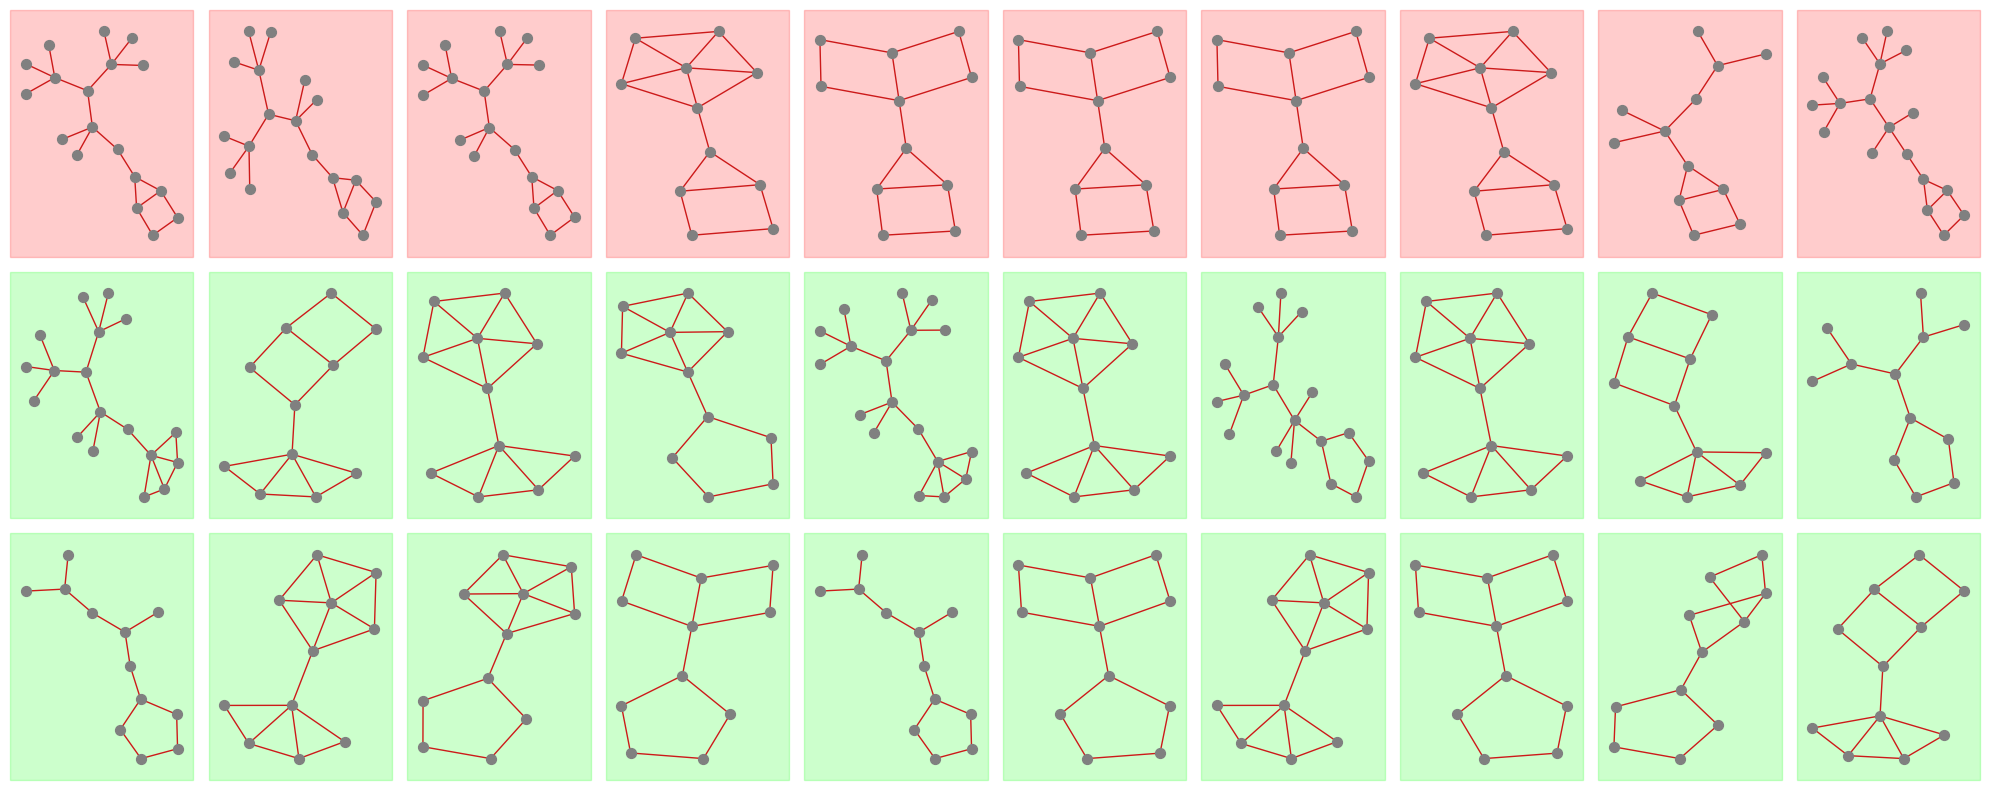

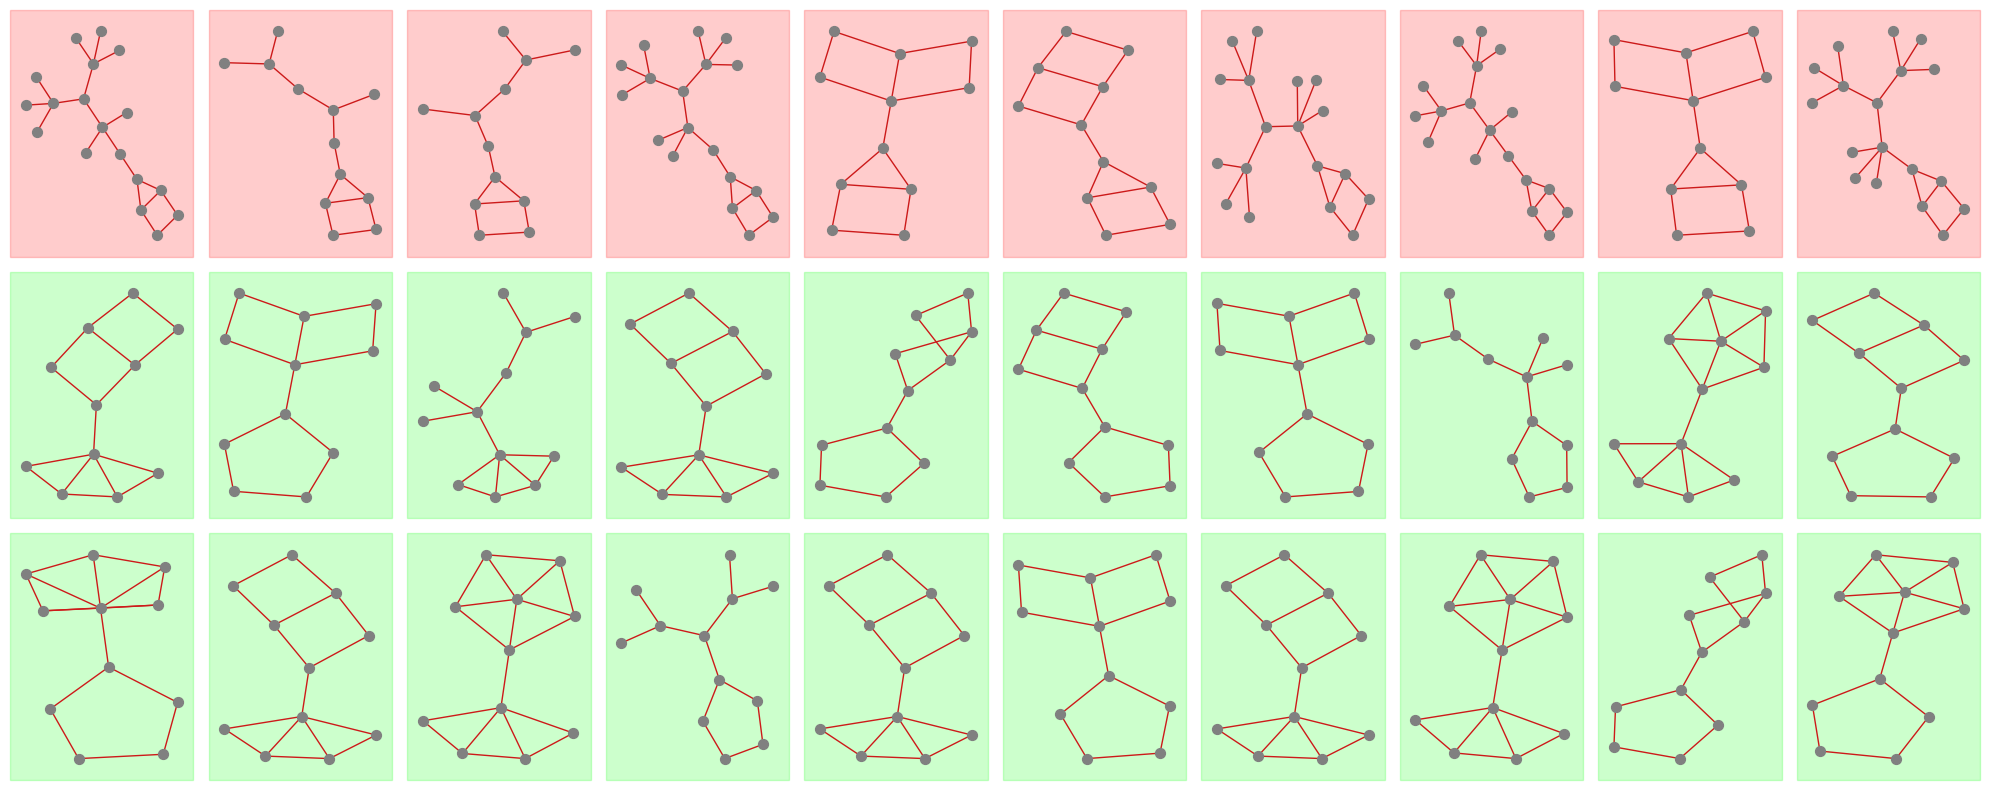

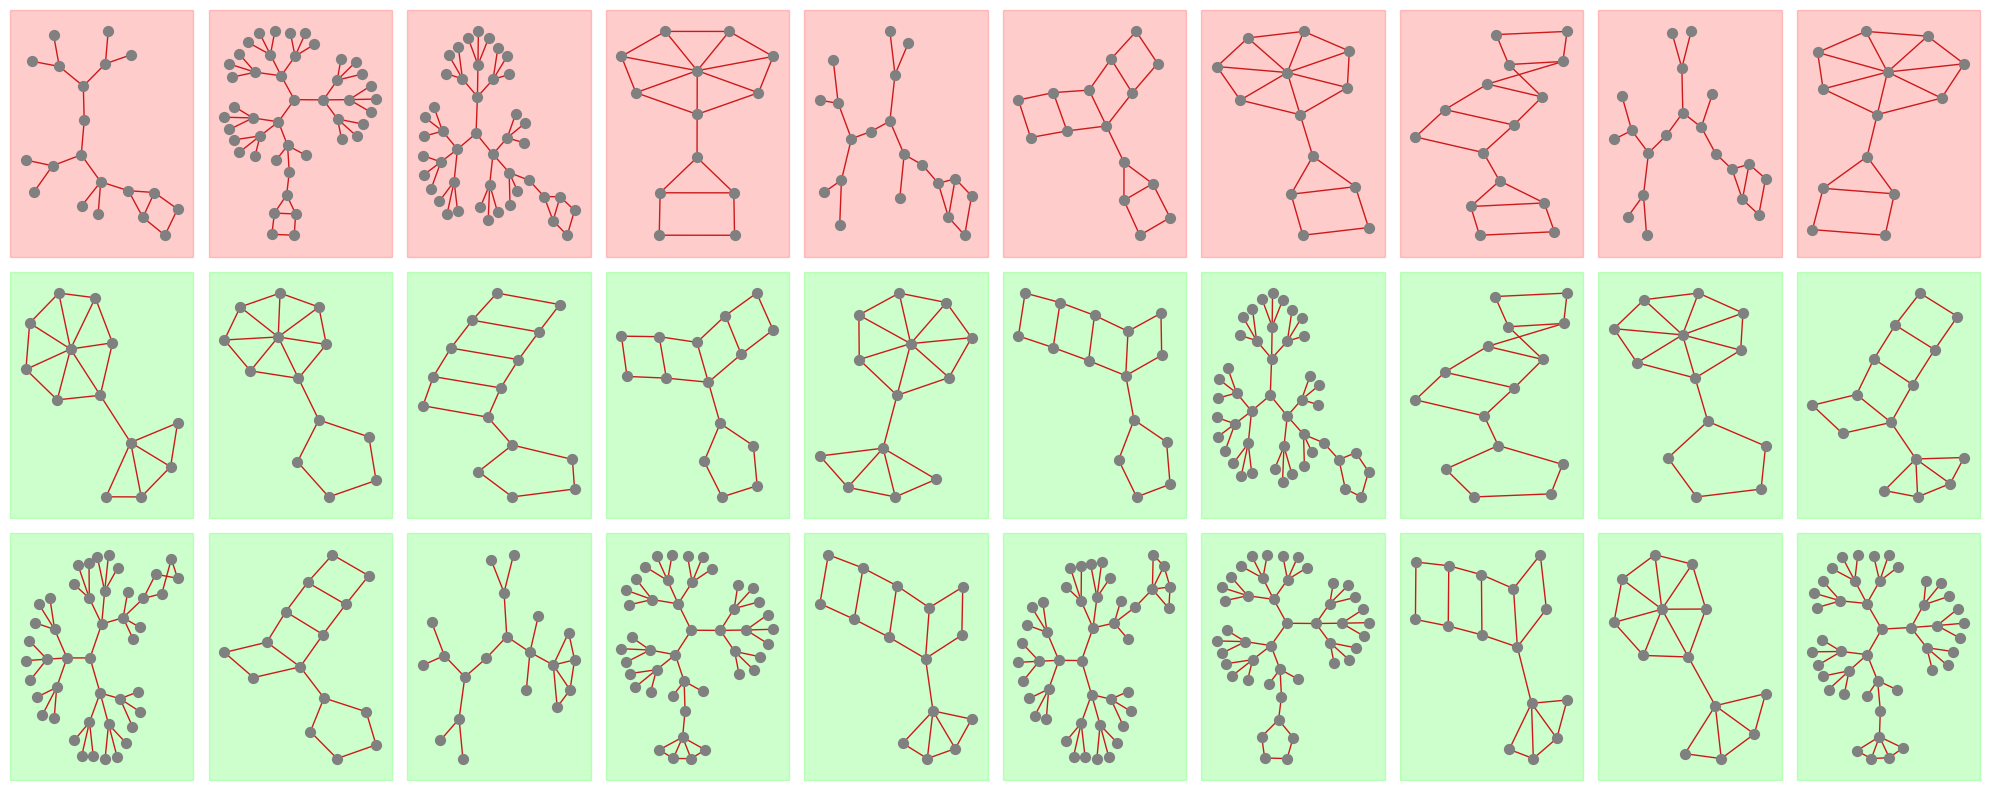

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import networkx as nx
from torch_geometric.utils import to_networkx
from torch_geometric.nn import GATConv, BatchNorm, global_mean_pool
import random


class GAT(torch.nn.Module):
    def __init__(self, in_channels, hid_channels=64, num_outputs=1, heads=8):
        super(GAT, self).__init__()
        self.node_emb = nn.Linear(in_channels, hid_channels)
        self.hid_channels = hid_channels
        self.heads = heads

        self.conv1 = GATConv(in_channels=hid_channels, out_channels=hid_channels // heads,
                             heads=heads, concat=True, dropout=0.1)
        self.bn1 = BatchNorm(hid_channels)
        self.relu1 = nn.ReLU()

        self.conv2 = GATConv(in_channels=hid_channels, out_channels=hid_channels,
                             heads=heads, concat=False, dropout=0.1)
        self.bn2 = BatchNorm(hid_channels)
        self.relu2 = nn.ReLU()

        self.predictor = nn.Sequential(
            nn.Linear(hid_channels, 2 * hid_channels),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(2 * hid_channels, hid_channels),
            nn.ReLU(),
            nn.Linear(hid_channels, num_outputs)
        )

    def forward(self, x, edge_index, edge_attr, batch):
        node_x = self.get_node_reps(x, edge_index, edge_attr)
        graph_x = global_mean_pool(node_x, batch)
        logits = self.predictor(graph_x)
        return logits

    def predict(self, x, edge_index, edge_attr, batch):
        logits = self.forward(x, edge_index, edge_attr, batch)
        return (logits > 0).float()

    def get_node_reps(self, x, edge_index, edge_attr):
        if x.size(1) != self.hid_channels:
            x = self.node_emb(x)

        x = self.conv1(x, edge_index)
        x = self.relu1(self.bn1(x))

        x = self.conv2(x, edge_index)
        x = self.relu2(self.bn2(x))

        return x


class EdgeImportanceGAT(torch.nn.Module):
    def __init__(self, in_channels, channels=64, heads=8):
        super(EdgeImportanceGAT, self).__init__()
        self.conv1 = GATConv(in_channels=in_channels, out_channels=channels // heads,
                             heads=heads, concat=True, dropout=0.1)
        self.conv2 = GATConv(in_channels=channels, out_channels=channels,
                             heads=heads, concat=False, dropout=0.1)
        self.mlp = nn.Sequential(
            nn.Linear(channels * 2, channels * 4),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(channels * 4, 1),
        )

    def forward(self, data):
        x = F.relu(self.conv1(data.x, data.edge_index))
        x = self.conv2(x, data.edge_index)
        row, col = data.edge_index
        edge_rep = torch.cat([x[row], x[col]], dim=-1)
        edge_score = self.mlp(edge_rep).view(-1)
        return x, edge_score


def load_graphs(pt_path):
    return torch.load(pt_path, weights_only=False)


def plot_graphs_separated_by_label(
        graph_list, edge_importance_model, gat_model, device, title, n_graphs=10
):
    plt.figure(figsize=(20, 8)) 

    graphs_label_1 = [g for g in graph_list if g.y.item() == 1]
    graphs_label_0 = [g for g in graph_list if g.y.item() == 0]

    selected_label_1 = random.sample(graphs_label_1, min(n_graphs, len(graphs_label_1)))
    selected_label_0_row2 = random.sample(graphs_label_0, min(n_graphs, len(graphs_label_0)))

    remaining_label_0 = [g for g in graphs_label_0 if g not in selected_label_0_row2]
    selected_label_0_row3 = random.sample(remaining_label_0, min(n_graphs, len(remaining_label_0)))

    for i, graph in enumerate(selected_label_1):
        graph = graph.to(device)

        edge_attr = torch.ones(graph.edge_index.size(1), 1).to(device) if graph.edge_attr is None else graph.edge_attr
        batch = graph.batch

        with torch.no_grad():
            logits = gat_model(graph.x, graph.edge_index, edge_attr, batch)
            pred_prob = torch.sigmoid(logits).item()
            pred_val = 1 if pred_prob > 0.5 else 0

            _, raw_edge_scores = edge_importance_model(graph)
            edge_scores = torch.sigmoid(raw_edge_scores)
            edge_min, edge_max = edge_scores.min(), edge_scores.max()
            if edge_max > edge_min:
                edge_scores = (edge_scores - edge_min) / (edge_max - edge_min)
            else:
                edge_scores = torch.zeros_like(edge_scores)

        G = to_networkx(graph, to_undirected=True)
        pos = nx.kamada_kawai_layout(G)

        ax = plt.subplot(3, n_graphs, i + 1)

        color = "#00FF00" if int(graph.y.item()) == pred_val else "#FF0000"
        rect = patches.Rectangle(
            (0, 0), 1, 1, transform=ax.transAxes, color=color, alpha=0.2, zorder=0, clip_on=False
        )
        ax.add_patch(rect)

        node_labels = {node: str(int(graph.x[node].item())) for node in range(graph.num_nodes)}

        edge_colors = []
        for j in range(len(graph.edge_index[0])):
            importance = edge_scores[j].cpu().item()
            r = 0.8 + 0.2 * importance
            g = 0.1 * (1 - importance)
            b = 0.1 * (1 - importance)
            edge_colors.append((r, g, b))

        nx.draw(
            G, pos, node_color="gray", edge_color=edge_colors, alpha=1.0,
            node_size=50, labels=node_labels, with_labels=False, ax=ax,
        )

    for i, graph in enumerate(selected_label_0_row2):
        graph = graph.to(device)

        edge_attr = torch.ones(graph.edge_index.size(1), 1).to(device) if graph.edge_attr is None else graph.edge_attr
        batch = graph.batch

        with torch.no_grad():
            logits = gat_model(graph.x, graph.edge_index, edge_attr, batch)
            pred_prob = torch.sigmoid(logits).item()
            pred_val = 1 if pred_prob > 0.5 else 0

            _, raw_edge_scores = edge_importance_model(graph)
            edge_scores = torch.sigmoid(raw_edge_scores)
            edge_min, edge_max = edge_scores.min(), edge_scores.max()
            if edge_max > edge_min:
                edge_scores = (edge_scores - edge_min) / (edge_max - edge_min)
            else:
                edge_scores = torch.zeros_like(edge_scores)

        G = to_networkx(graph, to_undirected=True)
        pos = nx.kamada_kawai_layout(G)

        ax = plt.subplot(3, n_graphs, n_graphs + i + 1)

        color = "#00FF00" if int(graph.y.item()) == pred_val else "#FF0000"
        rect = patches.Rectangle(
            (0, 0), 1, 1, transform=ax.transAxes, color=color, alpha=0.2, zorder=0, clip_on=False
        )
        ax.add_patch(rect)

        node_labels = {node: str(int(graph.x[node].item())) for node in range(graph.num_nodes)}

        edge_colors = []
        for j in range(len(graph.edge_index[0])):
            importance = edge_scores[j].cpu().item()
            r = 0.8 + 0.2 * importance
            g = 0.1 * (1 - importance)
            b = 0.1 * (1 - importance)
            edge_colors.append((r, g, b))

        nx.draw(
            G, pos, node_color="gray", edge_color=edge_colors, alpha=1.0,
            node_size=50, labels=node_labels, with_labels=False, ax=ax,
        )

    for i, graph in enumerate(selected_label_0_row3):
        graph = graph.to(device)

        edge_attr = torch.ones(graph.edge_index.size(1), 1).to(device) if graph.edge_attr is None else graph.edge_attr
        batch = graph.batch

        with torch.no_grad():
            logits = gat_model(graph.x, graph.edge_index, edge_attr, batch)
            pred_prob = torch.sigmoid(logits).item()
            pred_val = 1 if pred_prob > 0.5 else 0

            _, raw_edge_scores = edge_importance_model(graph)
            edge_scores = torch.sigmoid(raw_edge_scores)
            edge_min, edge_max = edge_scores.min(), edge_scores.max()
            if edge_max > edge_min:
                edge_scores = (edge_scores - edge_min) / (edge_max - edge_min)
            else:
                edge_scores = torch.zeros_like(edge_scores)

        G = to_networkx(graph, to_undirected=True)
        pos = nx.kamada_kawai_layout(G)

        ax = plt.subplot(3, n_graphs, 2 * n_graphs + i + 1)

        color = "#00FF00" if int(graph.y.item()) == pred_val else "#FF0000"
        rect = patches.Rectangle(
            (0, 0), 1, 1, transform=ax.transAxes, color=color, alpha=0.2, zorder=0, clip_on=False
        )
        ax.add_patch(rect)

        node_labels = {node: str(int(graph.x[node].item())) for node in range(graph.num_nodes)}

        edge_colors = []
        for j in range(len(graph.edge_index[0])):
            importance = edge_scores[j].cpu().item()
            r = 0.8 + 0.2 * importance
            g = 0.1 * (1 - importance)
            b = 0.1 * (1 - importance)
            edge_colors.append((r, g, b))

        nx.draw(
            G, pos, node_color="gray", edge_color=edge_colors, alpha=1.0,
            node_size=50, labels=node_labels, with_labels=False, ax=ax,
        )

    plt.tight_layout()
    plt.show()


def main():
    device = torch.device("cpu")

    # GAT model path
    gat_path = "../GAT_results/IV_Biasly_Connected/predictor.pt"

    train_path = "../data/IV_Biasly_Connected/train.pt"
    val_path = "../data/IV_Biasly_Connected/val.pt"
    test_path = "../data/IV_Biasly_Connected/test.pt"
    train_graphs = load_graphs(train_path)
    val_graphs = load_graphs(val_path)
    test_graphs = load_graphs(test_path)

    in_channels = train_graphs[0].x.size(1)

    heads = 8 

    gat_model = GAT(in_channels, hid_channels=64, num_outputs=1, heads=heads).to(device)
    edge_importance = EdgeImportanceGAT(in_channels, channels=64, heads=heads).to(device)

    gat_model.load_state_dict(torch.load(gat_path, map_location=device))
    gat_model.eval()
    edge_importance.eval()

    plot_graphs_separated_by_label(
        train_graphs, edge_importance, gat_model, device, "Train"
    )
    plot_graphs_separated_by_label(
        val_graphs, edge_importance, gat_model, device, "Val"
    )
    plot_graphs_separated_by_label(
        test_graphs, edge_importance, gat_model, device, "Test"
    )


if __name__ == "__main__":
    main()
